In [1]:
import random
import string
import re
import sys
import spacy
import torch

import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torch.utils.data as dt

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

from spacy import displacy

from nlp_project.notebook_utils import evaluate, split, save_scikit_model, load_scikit_model
from nlp_project.nn_utils import init_gpu
from nlp_project.nn_classifier import Data, Classifier
from nlp_project.nn_extra import EarlyStopping, AdaptLR

In [2]:
seed = 69420
np.random.seed(seed)
random.seed(seed)

In [3]:
%%capture # noqa [REMOVE TO RUN NOTEBOOK]

# Saved Models path
models_path = "./models/T1_DepParsing"

# Classification labels
labels = ["generated", "human"]

# Load spacy pipeline model
!{sys.executable} -m spacy download en_core_web_sm
#import en_core_web_sm
nlp_model = spacy.load("en_core_web_sm")

In [4]:
# Import main dataset
df = pd.read_csv("../../AUTEXTIFICATION/subtask_1/train.tsv", sep="\t")
df = df.drop("id", axis=1)

df

,text,label
0,you need to stop the engine and wait until it ...,generated
1,The Commission shall publish the report; an in...,generated
2,"I have not been tweeting a lot lately, but I d...",generated
3,I pass my exam and really thankgod for that bu...,human
4,The template will have 3 parts: a mustache sha...,human
...,...,...
33840,"@PierreJoye i have a server already, thanks fo...",human
33841,10. Article 13 of Council Directive 80/777/EEC...,human
33842,"Crying because I have to cry for you?. No. No,...",generated
33843,"However, it will continue to offer customers a...",generated


In [5]:
def extract_features(tree):
    features = []
    for token in tree:
        lemma = token.lemma_
        pos_tag = token.pos_
        dep_lab = token.dep_
        head = token.head
        if token.i < head.i:
            direction = "l"
        else:
            direction = "r"
        dfr = len(list(token.ancestors))
        # if not token.is_stop:
        features.append({
            "lem": lemma ,
            "pos": pos_tag, 
            "dep": dep_lab, 
            "head": head, 
            "dir": direction, 
            "dfr": dfr
        })
    return features

In [6]:
# Run SpaCy NLP pipeline on dataset
parsed_df = df.copy()
parsed_df["text"] = df["text"].apply(lambda x: nlp_model(x))

In [7]:
# Extract useful features
parsed_df["features"] = parsed_df["text"].apply(lambda x: extract_features(x))
parsed_df

,text,label,features
0,"(you, need, to, stop, the, engine, and, wait, ...",generated,"[{'lem': 'you', 'pos': 'PRON', 'dep': 'nsubj',..."
1,"(The, Commission, shall, publish, the, report,...",generated,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
2,"(I, have, not, been, tweeting, a, lot, lately,...",generated,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
3,"(I, pass, my, exam, and, really, thankgod, for...",human,"[{'lem': 'I', 'pos': 'PRON', 'dep': 'nsubj', '..."
4,"(The, template, will, have, 3, parts, :, a, mu...",human,"[{'lem': 'the', 'pos': 'DET', 'dep': 'det', 'h..."
...,...,...,...
33840,"(@PierreJoye, i, have, a, server, already, ,, ...",human,"[{'lem': '@PierreJoye', 'pos': 'PROPN', 'dep':..."
33841,"(10, ., Article, 13, of, Council, Directive, 8...",human,"[{'lem': '10', 'pos': 'X', 'dep': 'ROOT', 'hea..."
33842,"(Crying, because, I, have, to, cry, for, you, ...",generated,"[{'lem': 'cry', 'pos': 'VERB', 'dep': 'ROOT', ..."
33843,"(However, ,, it, will, continue, to, offer, cu...",generated,"[{'lem': 'however', 'pos': 'ADV', 'dep': 'advm..."


In [8]:
# Example structure
displacy.render(parsed_df["text"][0], jupyter=True, style='dep')

In [9]:
# vectorizer = CountVectorizer(stop_words="english")
# vectorizer = TfidfVectorizer(min_df=4, max_df=0.6, stop_words="english")
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6)

parsed_df["text_lem"] = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))

In [10]:
x, y = parsed_df["text_lem"], parsed_df["label"]
x_train, x_val, x_test, y_train, y_val, y_test = split(
    x, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [11]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes",
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=100000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.8,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC", 
    "model": svc_clf, 
    "subsample": 0.7,
    "usecached": usecached,
})

In [12]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 0.1}
Best CV score: 0.7058652111114293
              precision    recall  f1-score   support

   generated       0.67      0.78      0.72      3360
       human       0.74      0.62      0.67      3409

    accuracy                           0.70      6769
   macro avg       0.71      0.70      0.70      6769
weighted avg       0.71      0.70      0.70      6769



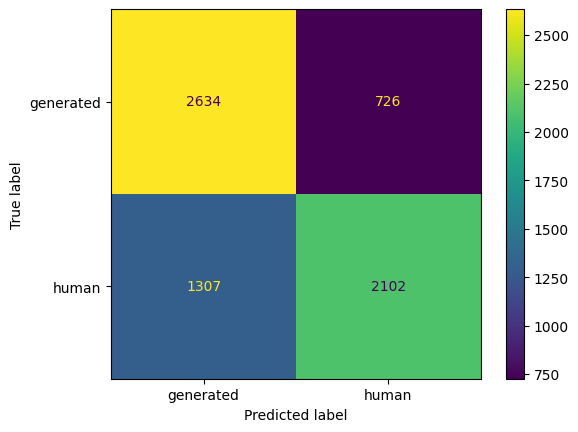

Linear Regression
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
Best CV score: 0.7325946445060019
              precision    recall  f1-score   support

   generated       0.75      0.75      0.75      3360
       human       0.76      0.76      0.76      3409

    accuracy                           0.76      6769
   macro avg       0.76      0.76      0.76      6769
weighted avg       0.76      0.76      0.76      6769



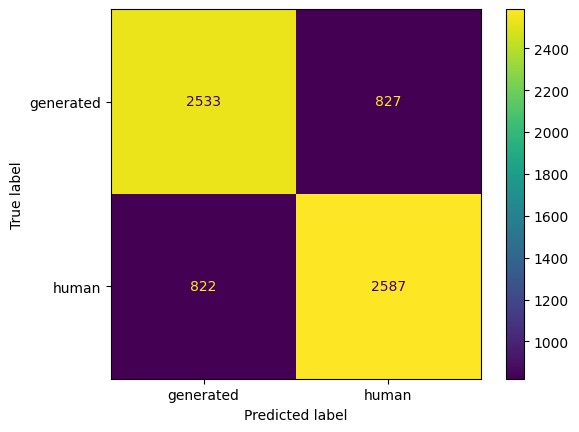

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.742674801061008
              precision    recall  f1-score   support

   generated       0.78      0.78      0.78      3360
       human       0.78      0.78      0.78      3409

    accuracy                           0.78      6769
   macro avg       0.78      0.78      0.78      6769
weighted avg       0.78      0.78      0.78      6769



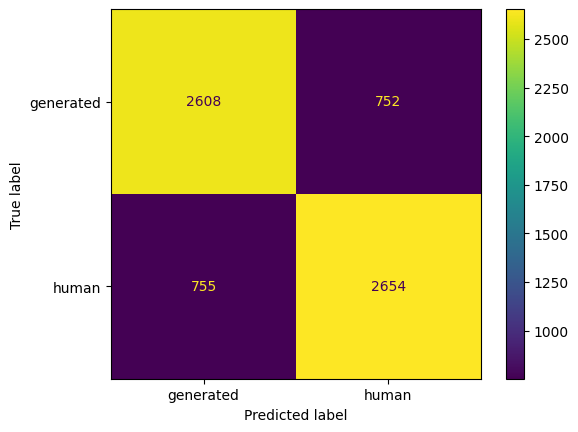

In [13]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [14]:
x_lem = parsed_df["features"].apply(lambda x: " ".join([t["lem"] for t in x]))
x_pos = parsed_df["features"].apply(lambda x: " ".join([t["pos"] for t in x]))
x_avgdfr = parsed_df["features"].apply(lambda x: sum(t["dfr"] for t in x) / len(x))
y = parsed_df["label"]
x_train_lem, x_val_lem, x_test_lem, y_train, y_val, y_test = split(
    x_lem, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train_pos, x_val_pos, x_test_pos, y_train, y_val, y_test = split(
    x_pos, y, test_size=0.2, val_size=0.0, seed=seed
)
x_train_avgdfr, x_val_avgdfr, x_test_avgdfr, y_train, y_val, y_test = split(
    x_avgdfr, y, test_size=0.2, val_size=0.0, seed=seed
)

In [15]:
# Vectorizing POS tags with a TfidfVectorizer gives much better results overall, however
# using a CountVectorizer has marginally better results for tree-based methods

# Vectorize lemmas
vectorizer = TfidfVectorizer(min_df=4, ngram_range=(2,2))
x_train_lem = vectorizer.fit_transform(x_train_lem)
x_test_lem = vectorizer.transform(x_test_lem)

# Vectorize POS tags
vectorizer = TfidfVectorizer(min_df=4)
x_train_pos = vectorizer.fit_transform(x_train_pos)
x_test_pos = vectorizer.transform(x_test_pos)

# Normalize average distance from root
mms = MinMaxScaler()

x_train_avgdfr = mms.fit_transform(x_train_avgdfr.values.reshape(-1, 1))
x_test_avgdfr = mms.transform(x_test_avgdfr.values.reshape(-1, 1))

x_train_avgdfr = sps.csr_matrix(x_train_avgdfr)
x_test_avgdfr = sps.csr_matrix(x_test_avgdfr)

# Concatenate vectors
x_train = sps.hstack([x_train_lem, x_train_pos, x_train_avgdfr])
x_test = sps.hstack([x_test_lem, x_test_pos, x_test_avgdfr])

In [19]:
models = []
usecached = False

# Naive Bayes
nb = MultinomialNB()
nb_param = {"alpha":[0.001, 0.01, 0.1, 1, 10, 100]}
nb_clf = GridSearchCV(nb, nb_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Naive Bayes", 
    "model": nb_clf,
    "usecached": usecached,
})

# Logistic Regression
lr = LogisticRegression(max_iter=100000)
lr_param = [{
    "solver": ["liblinear"], 
    "penalty": ["l1", "l2"],
    "C":[0.01, 0.1, 1, 10]
},{
    "solver": ("lbfgs", "sag", "saga"), 
    "penalty": ["l2"],
    "C":[0.01, 0.1, 1]
}]
lr_clf = GridSearchCV(lr, lr_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Linear Regression",
    "model": lr_clf,
    "subsample": 0.8,
    "usecached": usecached,
})

# SVC
svc = SVC()
svc_param = {"kernel": ["rbf"], "C": [0.1, 1, 10]}
svc_clf = GridSearchCV(svc, svc_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "SVC", 
    "model": svc_clf,
    "subsample": 0.7,
    "usecached": usecached,
})

# Decision Tree
dtree = DecisionTreeClassifier()
dtree_param = {
    "criterion": ["gini", "entropy"], 
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    "max_features": [None, "sqrt", "log2"],
}
dtree_clf =  GridSearchCV(dtree, dtree_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Decision Tree",
    "model": dtree_clf,
    "usecached": usecached,
})

# Random Forest
rf = RandomForestClassifier()
rf_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
rf_clf =  GridSearchCV(rf, rf_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Random Forest",
    "model": rf_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

# Extra Trees
et = ExtraTreesClassifier()
et_param = {
    # "n_estimators": [50, 100, 200, 400],
    # "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    # "min_samples_split": [2, 4, 8],
    # "min_samples_leaf": [1, 2, 4],
    # "max_features": [None, "sqrt", "log2"],
    # "oob_score": [True, False]
}
et_clf =  GridSearchCV(et, et_param, cv=5, scoring="f1_micro", verbose=1)
models.append({
    "name": "Extra Trees",
    "model": et_clf,
    "subsample": 0.6,
    "usecached": usecached,
})

In [20]:
for model in models:
    if model["usecached"]:
        cache = load_scikit_model(models_path, model["name"])
        if cache:
            model["best"] = cache
            print(f"Restored model for {model['name']}")
            continue
        else:
            print(f"Couldn't restore model for {model['name']}")
            
    x_train_, y_train_ = x_train, y_train
    if "subsample" in model.keys():
        x_train_, _, y_train_, _ = train_test_split(
            x_train, 
            y_train, 
            test_size=model["subsample"], 
            stratify=y_train
        )
            
    print(f"Training {model['name']}")        
    model["model"].fit(x_train_, y_train_)
    
    print("Found best model")
    model["best"] = model["model"].best_estimator_
    model["best"].fit(x_train, y_train)
    print("Trained best model")
    
    save_scikit_model(models_path, model["best"], model["name"])

Training Naive Bayes
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Linear Regression
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best model
Trained best model
Training SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Found best model
Trained best model
Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Found best model
Trained best model
Training Random Forest
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model
Training Extra Trees
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Found best model
Trained best model


Naive Bayes
Best parameters: {'alpha': 0.1}
Best CV score: 0.7223740880616375
              precision    recall  f1-score   support

   generated       0.67      0.84      0.74      3360
       human       0.79      0.58      0.67      3409

    accuracy                           0.71      6769
   macro avg       0.73      0.71      0.71      6769
weighted avg       0.73      0.71      0.71      6769



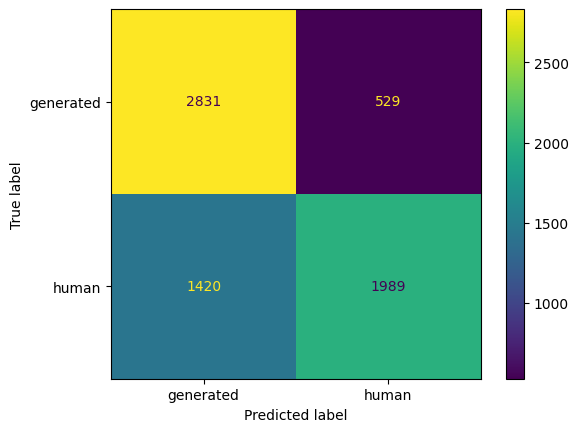

Linear Regression
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.7614035087719297
              precision    recall  f1-score   support

   generated       0.78      0.79      0.79      3360
       human       0.79      0.78      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.79      0.79      6769
weighted avg       0.79      0.79      0.79      6769



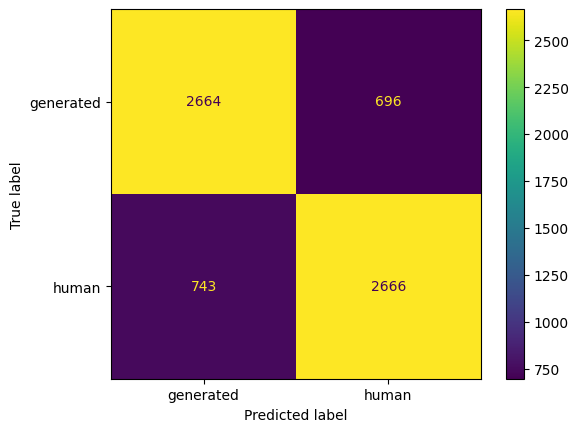

SVC
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best CV score: 0.7732084880636605
              precision    recall  f1-score   support

   generated       0.81      0.81      0.81      3360
       human       0.81      0.81      0.81      3409

    accuracy                           0.81      6769
   macro avg       0.81      0.81      0.81      6769
weighted avg       0.81      0.81      0.81      6769



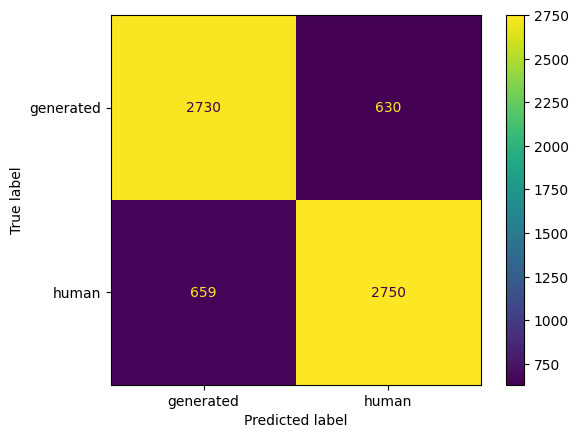

Decision Tree
Best parameters: {'criterion': 'gini', 'max_features': None}
Best CV score: 0.6916091168604088
              precision    recall  f1-score   support

   generated       0.69      0.69      0.69      3360
       human       0.69      0.69      0.69      3409

    accuracy                           0.69      6769
   macro avg       0.69      0.69      0.69      6769
weighted avg       0.69      0.69      0.69      6769



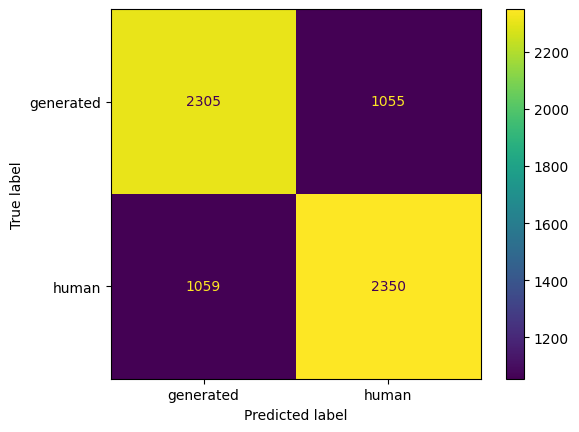

Random Forest
Best parameters: {'criterion': 'entropy'}
Best CV score: 0.7622345337026777
              precision    recall  f1-score   support

   generated       0.79      0.78      0.78      3360
       human       0.78      0.79      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.79      0.79      6769
weighted avg       0.79      0.79      0.79      6769



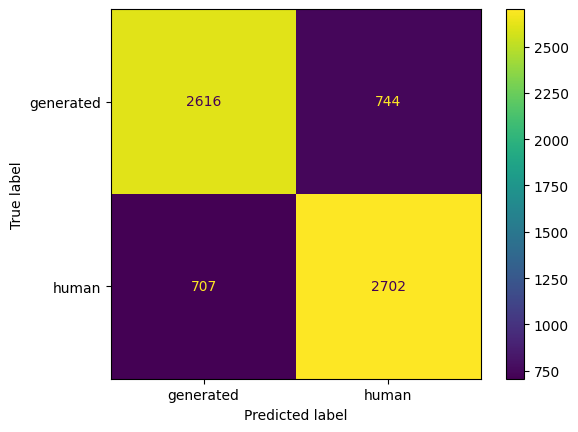

Extra Trees
Best parameters: {'criterion': 'gini'}
Best CV score: 0.7756232686980609
              precision    recall  f1-score   support

   generated       0.79      0.77      0.78      3360
       human       0.78      0.80      0.79      3409

    accuracy                           0.79      6769
   macro avg       0.79      0.78      0.78      6769
weighted avg       0.79      0.79      0.79      6769



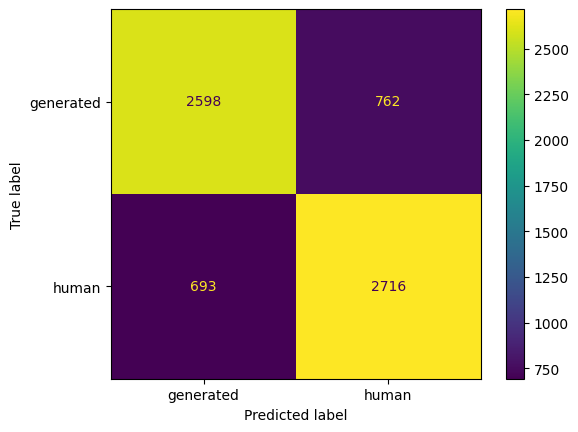

In [21]:
for model in models:
    print(f"{model['name']}")
    if hasattr(model["model"], "cv_results_"):
        print(f"Best parameters: {model['model'].best_params_}")
        print(f"Best CV score: {model['model'].best_score_}")
    y_pred = model['best'].predict(x_test)
    evaluate(y_test, y_pred, labels=labels)

In [22]:
epochs = 100
batch_size = 32

num_workers = 8 # Tune it based on your machine specs
device = init_gpu()

In [23]:
y_ = LabelBinarizer().fit_transform(y).astype(float)
x_train_lem, x_val_lem, x_test_lem, y_train, y_val, y_test = split(
    x_lem, y_, test_size=0.1, val_size=0.1, seed=seed
)
x_train_pos, x_val_pos, x_test_pos, y_train, y_val, y_test = split(
    x_pos, y_, test_size=0.1, val_size=0.1, seed=seed
)
x_train_avgdfr, x_val_avgdfr, x_test_avgdfr, y_train, y_val, y_test = split(
    x_avgdfr, y_, test_size=0.1, val_size=0.1, seed=seed
)

In [24]:
# Vectorize lemmas
vectorizer = TfidfVectorizer(min_df=4, max_df=0.6)
x_train_lem = vectorizer.fit_transform(x_train_lem)
x_val_lem = vectorizer.transform(x_val_lem)
x_test_lem = vectorizer.transform(x_test_lem)

# Vectorize POS tags
vectorizer = TfidfVectorizer()
x_train_pos = vectorizer.fit_transform(x_train_pos)
x_val_pos = vectorizer.transform(x_val_pos)
x_test_pos = vectorizer.transform(x_test_pos)

# Normalize average distance from root
mms = MinMaxScaler()

x_train_avgdfr = mms.fit_transform(x_train_avgdfr.values.reshape(-1, 1))
x_val_avgdfr = mms.transform(x_val_avgdfr.values.reshape(-1, 1))
x_test_avgdfr = mms.transform(x_test_avgdfr.values.reshape(-1, 1))

x_train_avgdfr = sps.csr_matrix(x_train_avgdfr)
x_val_avgdfr = sps.csr_matrix(x_val_avgdfr)
x_test_avgdfr = sps.csr_matrix(x_test_avgdfr)

# Concatenate vectors
x_train = sps.hstack([x_train_lem, x_train_pos, x_train_avgdfr])
x_val = sps.hstack([x_val_lem, x_val_pos, x_val_avgdfr])
x_test = sps.hstack([x_test_lem, x_test_pos, x_test_avgdfr])

In [25]:
ds_train = Data(x_train, y_train, x_type=np.float32)
ds_val = Data(x_val, y_val, x_type=np.float32)
ds_test = Data(x_test, y_test, x_type=np.float32)

train_dl = dt.DataLoader(
    ds_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
val_dl = dt.DataLoader(ds_val,     
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    # pin_memory_device=device.type, # Doesn't work on CPU
)
test_dl = dt.DataLoader(ds_test, batch_size=batch_size, shuffle=False)

/home/riga/Documents/NLP/NLP_Project/nlp_project/nn_classifier.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  torch.LongTensor([x_coo.row, x_coo.col]),


In [26]:
in_dim = x_train.shape[1]
out_dim = 1 if len(labels) <= 2 else len(labels)

In [27]:
class Network(Classifier):
    def __init__(self, in_dim, out_dim, binary_classifier=False, device=torch.device("cpu"), verbose=True):
        super().__init__(binary_classifier, device, verbose)
        self.l1 = nn.Linear(in_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, out_dim)
        self.dp = nn.Dropout(p=0.6)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dp(x)
        x = self.sig(self.l3(x))
        return x

In [28]:
nn_model = Network(in_dim, out_dim, binary_classifier=True, device=device)
loss = nn.BCELoss()
optimizer = opt.Adam(nn_model.parameters(), lr=0.01)
nn_model.compile(loss, optimizer)

In [29]:
earlystop = EarlyStopping(metric="val_acc", patience=10, baseline=0.7)
lradjust = AdaptLR(metric="val_acc", patience=5, factor=0.1)
callbacks = [earlystop, lradjust]

# nn_model.load_state_dict(torch.load(models_path + "NN Model"))
history = nn_model.train_loop(train_dl, epochs, data_val=val_dl, callbacks=callbacks)

Epoch 1 -- loss: 0.0153841 acc: 0.7447186 val_loss: 0.0139746 val_acc: 0.7719350
Epoch 2 -- loss: 0.0117214 acc: 0.8239031 val_loss: 0.0141585 val_acc: 0.7787297
Epoch 3 -- loss: 0.0096269 acc: 0.8648618 val_loss: 0.0155458 val_acc: 0.7778434
Epoch 4 -- loss: 0.0077164 acc: 0.8948885 val_loss: 0.0162946 val_acc: 0.7686854
Epoch 5 -- loss: 0.0063787 acc: 0.9161250 val_loss: 0.0188428 val_acc: 0.7787297
Epoch 6 -- loss: 0.0052734 acc: 0.9301596 val_loss: 0.0216960 val_acc: 0.7725258
Epoch 7 -- loss: 0.0044277 acc: 0.9434555 val_loss: 0.0227515 val_acc: 0.7698671
Reducing lr to 0.0010
Epoch 8 -- loss: 0.0039033 acc: 0.9488477 val_loss: 0.0244794 val_acc: 0.7677991
Epoch 9 -- loss: 0.0028614 acc: 0.9646181 val_loss: 0.0281460 val_acc: 0.7742984
Epoch 10 -- loss: 0.0025282 acc: 0.9676836 val_loss: 0.0283783 val_acc: 0.7816839
Epoch 11 -- loss: 0.0023433 acc: 0.9725956 val_loss: 0.0280362 val_acc: 0.7816839
Epoch 12 -- loss: 0.0021524 acc: 0.9738514 val_loss: 0.0287412 val_acc: 0.7825702
Epo

{'acc': tensor(0.7793), 'loss': 0.03602513679728159}
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      1680
         1.0       0.79      0.76      0.78      1704

    accuracy                           0.78      3384
   macro avg       0.78      0.78      0.78      3384
weighted avg       0.78      0.78      0.78      3384



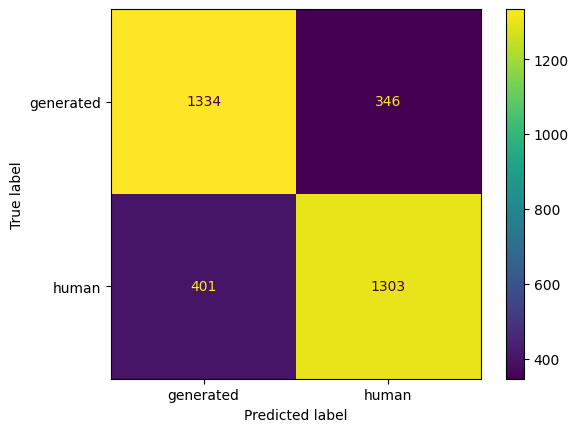

In [30]:
y_pred, metrics = nn_model.test_loop(test_dl)
print(metrics)
evaluate(y_test, y_pred, labels=labels)

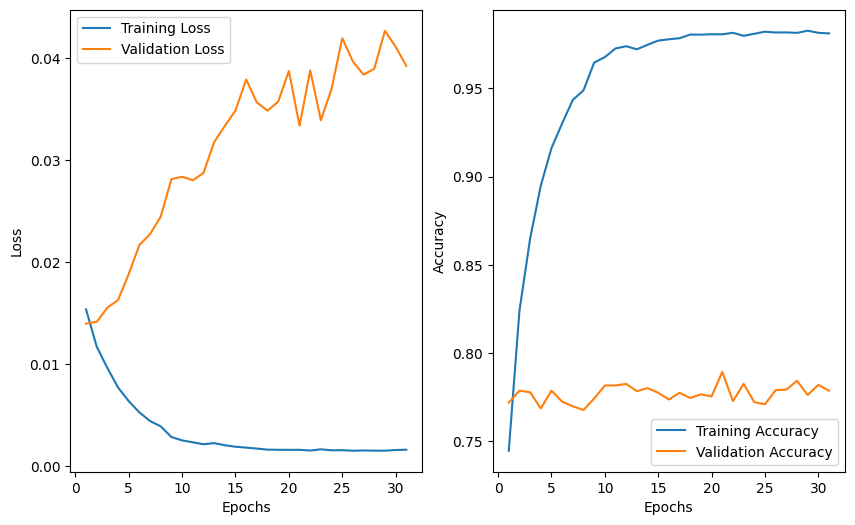

In [31]:
history = nn_model.history
plt_epochs = [h["epoch"] for h in history]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

tl = ax1.plot(plt_epochs, [h["loss"] for h in history], label="Training Loss")
vl = ax1.plot(plt_epochs, [h["val_loss"] for h in history], label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ta = ax2.plot(plt_epochs, [h["acc"] for h in history], label="Training Accuracy")
va = ax2.plot(plt_epochs, [h["val_acc"] for h in history], label="Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

In [34]:
torch.save(nn_model.state_dict(), models_path + "/" + "NN Model")